In [ ]:
import sys
import os
import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import mpl_toolkits.axisartist
# from mpl_toolkits.axes_grid1 import host_subplot

import scipy.interpolate
import scipy.optimize
import scipy.stats
import pandas as pd

# import statsmodels.formula.api as smformula
# import dateutil
# from collections import OrderedDict

In [28]:
from IPython.display import display, HTML
%matplotlib notebook
plt.style.use('seaborn-paper')

In [2]:
# constants
FN = '2017_MAT_rep{}data.xlsx'
treatments = ['Low', 'High', 'Super High']

In [3]:
def load_rep_catch_data(rep, filename_pattern):
    df = pd.read_excel(filename_pattern.format(rep))

    if rep in [1,2]:
        foo = df[['Date Collected','Treatment','Row','Trap #','Pink','Blue','Yellow','Arc Yellow']].copy(deep=True)
        foo = foo[pd.notnull(foo['Date Collected'])]
        foo.loc[:,['Pink','Blue','Yellow','Arc Yellow']] = foo.loc[:,['Pink','Blue','Yellow','Arc Yellow']].fillna(value=0)
        foo['Total'] = foo.loc[:,['Pink','Blue','Yellow','Arc Yellow']].sum(axis=1)
    else:
        foo = df[['Date','Treatment','Row','Trap #','# recaptured']].copy(deep=True)
        foo.rename(columns={'Date':'Date Collected', '# recaptured':'Total'}, inplace=True)
        foo = foo[pd.notnull(foo['Date Collected'])]
        foo['Total'] = foo['Total'].fillna(value=0)

    return foo

## Trap locations

In [4]:
COLSPACE = 4.5 # distance between trees along a row
ROWSPACE = 8.5 # distance between rows

FIRST_ROW_BREAK_DIST = 40 # distance between traps 4 and 5 on first row 

# Trap x positions
# even rows (starting with 0)
tx0 = (np.linspace(0, 90, 4)+15)*COLSPACE
tx0 = np.concatenate((tx0, [0*COLSPACE, 30*COLSPACE]+tx0[-1]+FIRST_ROW_BREAK_DIST*COLSPACE))
# odd rows
tx1 = (np.linspace(0, 90, 4)+30)*COLSPACE
tx1 = np.concatenate((tx1, [0*COLSPACE]+tx1[-1]+FIRST_ROW_BREAK_DIST*COLSPACE))

# nominal trap positions
tx = []
ty = []
for row in range(5,50+1, 5):
    if row%10 == 5:
        tx.extend(tx0)
        ty.extend([row*ROWSPACE]*len(tx0))
    else:
        tx.extend(tx1)
        ty.extend([row*ROWSPACE]*len(tx1))

# high block positions
hbx = []
hby = []
for row in range(5,50+1, 5):
    if row%10 == 5:
        hbx.extend(tx1)
        hby.extend([row*ROWSPACE]*len(tx1))
    else:
        hbx.extend(tx0)
        hby.extend([row*ROWSPACE]*len(tx0))

# super-high block positions
tmp = np.linspace(0, 120*COLSPACE, 17)
#tmp = tmp*COLSPACE
shbx0 = np.concatenate((tmp, np.linspace(0,30*COLSPACE,5)+(105*COLSPACE+FIRST_ROW_BREAK_DIST*COLSPACE)))
shbx0 = shbx0[np.in1d(shbx0, tx0, invert=True)]
shbx1 = np.concatenate((tmp+7.5*COLSPACE, np.linspace(0,30*COLSPACE,5)+(105*COLSPACE+FIRST_ROW_BREAK_DIST*COLSPACE)))
# shbx1 = np.concatenate((tmp+7.5*COLSPACE, np.linspace(0,30,5)+(105+FIRST_ROW_BREAK_DIST)))
shbx1 = shbx1[np.in1d(shbx1, tx1, invert=True)]
shbx = []
shby = []
for row in range(5,50+1, 5):
    if row%10 == 5:
        shbx.extend(shbx0)
        shby.extend([row*ROWSPACE]*len(shbx0))
    else:
        shbx.extend(shbx1)
        shby.extend([row*ROWSPACE]*len(shbx1))


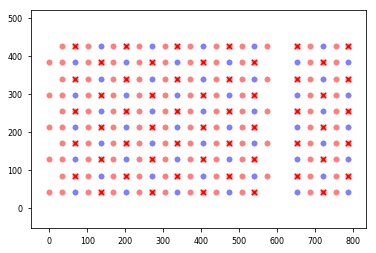

In [5]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(tx, ty, color='b', alpha=0.5)
ax.scatter(hbx, hby, marker='x', color='r')
ax.scatter(shbx, shby, color='r', alpha=0.5)
ax.set_aspect('equal','datalim')

Low: 2017-04-13; $\Sigma_{all}$=1700; $\Sigma_{inner}$=0
Low: 2017-04-17; $\Sigma_{all}$=46; $\Sigma_{inner}$=0
Low: 2017-04-27; $\Sigma_{all}$=1624; $\Sigma_{inner}$=0
Low: 2017-05-01; $\Sigma_{all}$=40; $\Sigma_{inner}$=0
High: 2017-04-13; $\Sigma_{all}$=1582; $\Sigma_{inner}$=0
High: 2017-04-17; $\Sigma_{all}$=34; $\Sigma_{inner}$=0
High: 2017-04-27; $\Sigma_{all}$=1506; $\Sigma_{inner}$=0
High: 2017-05-01; $\Sigma_{all}$=25; $\Sigma_{inner}$=0
Super High: 2017-04-13; $\Sigma_{all}$=1376; $\Sigma_{inner}$=0
Super High: 2017-04-17; $\Sigma_{all}$=54; $\Sigma_{inner}$=0
Super High: 2017-04-27; $\Sigma_{all}$=717; $\Sigma_{inner}$=0
Super High: 2017-05-01; $\Sigma_{all}$=22; $\Sigma_{inner}$=0
Low: 2017-05-04; $\Sigma_{all}$=1632; $\Sigma_{inner}$=0
Low: 2017-05-08; $\Sigma_{all}$=37; $\Sigma_{inner}$=0
Low: 2017-05-18; $\Sigma_{all}$=1809; $\Sigma_{inner}$=0
Low: 2017-05-22; $\Sigma_{all}$=132; $\Sigma_{inner}$=0
High: 2017-05-04; $\Sigma_{all}$=1400; $\Sigma_{inner}$=0
High: 2017-05-

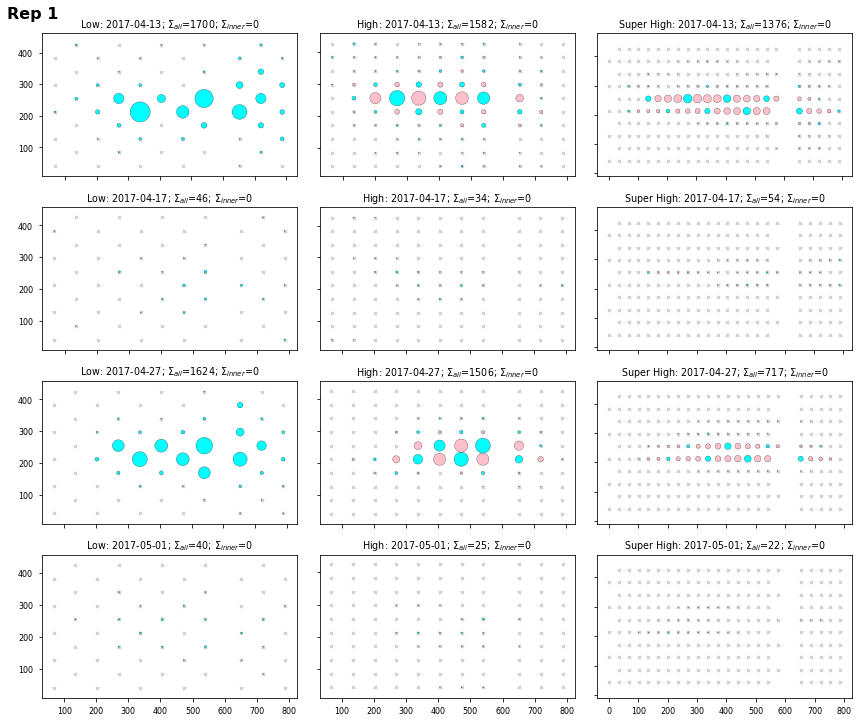

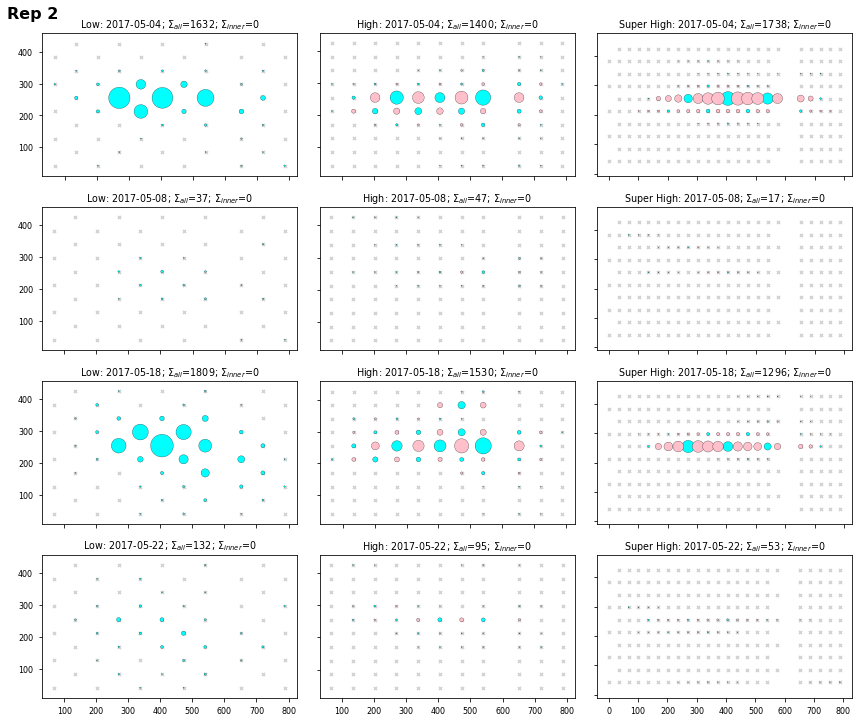

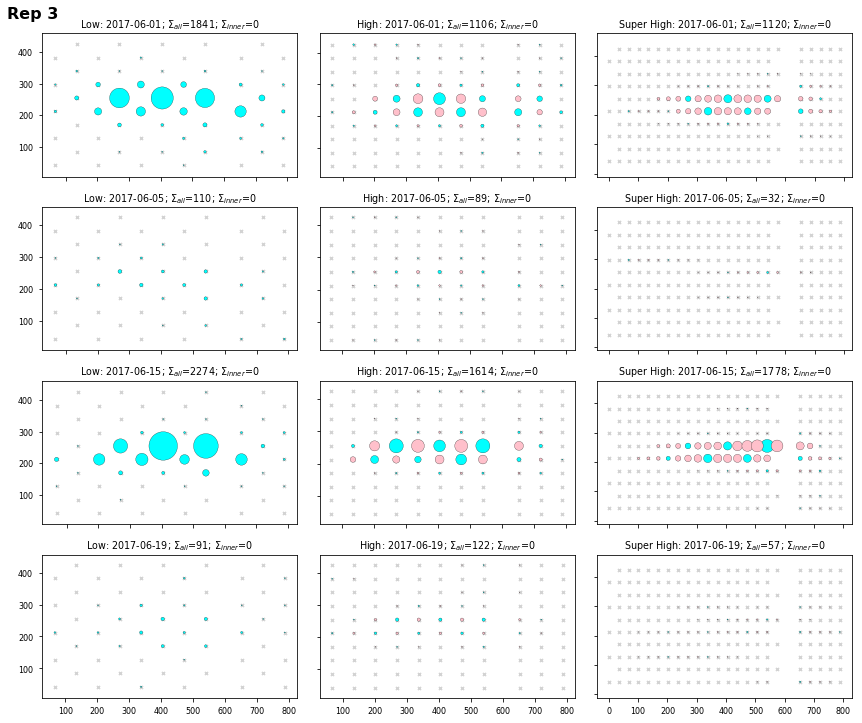

In [6]:
innerx0 = tx0[2]*COLSPACE # incluse
innerx1 = tx0[3]*COLSPACE # not inclusive

treatments = ['Low', 'High', 'Super High']

for rep in [1,2,3]:
    df = load_rep_catch_data(rep, FN)
    # and x,y cols for positions
    df['x'] = df.apply(lambda r: tx0[int(r['Trap #'])-1] 
                       if int(r['Row']%10) == 5
                       else tx1[int(r['Trap #'])-1],
                       axis=1) 
    df['y'] = df['Row'] * ROWSPACE
#     df['x'] = df['x'] * COLSPACE
    
    fig = plt.figure(figsize=(12,10))
    gs = mpl.gridspec.GridSpec(4,len(treatments))

    for ti, treatment in enumerate(treatments):
        tmp = df[df['Treatment'] == treatment]
        service_dates = pd.to_datetime(tmp['Date Collected'].unique())
        assert len(service_dates) == 4

        if treatment == 'High':
            bx = hbx
            by = hby
        elif treatment == 'Super High':
            bx = shbx
            by = shby
        else:
            assert treatment == 'Low'
            bx = []
            by = []
            
        for di, service_date in enumerate(service_dates):
            foo = df[df['Treatment'] == treatment].copy(deep=True)
            foo = foo[foo['Date Collected'] == service_date]

            foo['isTrap'] = True
            foo_traps = foo.copy(deep=True) # keep a copy of just the traps
            
            # Add in the blocks
            foo = foo.append(pd.DataFrame({'x':bx, 'y':by}),
                       ignore_index=True)
            foo.sort_values(['y','x'], inplace=True)
            foo.reset_index(inplace=True, drop=True)
            
            # interpolate
            ## 1D (row wise) interpolation
            out = foo.copy(deep=True)
            out['iT'] = np.nan
            for row in sorted(foo['y'].unique()):
                tmp = foo[foo['y']==row].sort_values('x')
                tmp2 = tmp.dropna(subset=['Total'])
                iT = scipy.interpolate.interp1d(tmp2['x'], tmp2['Total'], 
                                                kind='linear', copy=True, bounds_error=False, 
                                                fill_value=np.nan, assume_sorted=False)(tmp['x'])
                out.loc[tmp.index,'iT'] = iT
                
            # sums
            tmp = out#.copy(deep=True)
            sum_all = tmp['iT'].sum()
            tmp = tmp[(tmp['x']>=innerx0) & (tmp['x']<innerx1)] # restrict to inner columns
            #tmp = tmp[(tmp['y']>=25) & (tmp['y']<=30)] # restrict rows too?
            sum_inner_cols = tmp['iT'].sum()
            
            # Plot
            ax = fig.add_subplot(gs[di,ti])
            # all traps+hats (markers)
            ax.scatter(x=out['x'], y=out['y'], s=10, marker='x', color='lightgray')

            # inner
            tmp1 = out[(out['x']>=innerx0) & (out['x']<innerx1)]
            tmp = tmp1[tmp1['isTrap']==True]
            ax.scatter(tmp['x'], tmp['y'], tmp['iT'], color='b', edgecolor='k')
            tmp = tmp1[tmp1['isTrap']!=True]
            ax.scatter(tmp['x'], tmp['y'], tmp['iT'], color='r', edgecolor='k')
            
            # non inner
            tmp2 = out.loc[out.index.difference(tmp1.index)]
            tmp = tmp2[tmp2['isTrap']==True]
            ax.scatter(tmp['x'], tmp['y'], tmp['iT'], color='cyan', edgecolor='k')
            tmp = tmp2[tmp2['isTrap']!=True]
            ax.scatter(tmp['x'], tmp['y'], tmp['iT'], color='pink', edgecolor='k')

            ax.set_aspect('equal','datalim')
            
            t = "{}: {}".format(treatment, pd.to_datetime(service_date).strftime('%Y-%m-%d'))
            t += r"; $\Sigma_{all}$="+str(int(sum_all))
            t += r"; $\Sigma_{inner}$="+str(int(sum_inner_cols))
            ax.set_title(t)
            print(t)

            if ti>0:
                ax.set_yticklabels([])
            if di<len(service_dates)-1:
                ax.set_xticklabels([])
            
#             break
#         break
                
    ax.text(0,1, 'Rep {}'.format(rep), transform=fig.transFigure, fontsize=16, fontweight='bold', va='top', ha='left')

    # gs.tight_layout(fig, rect=[])
    fig.tight_layout()

    fig.savefig('rep{}_inferred.png'.format(rep))
#     break

DatetimeIndex(['2017-04-13', '2017-04-17', '2017-04-27', '2017-05-01'], dtype='datetime64[ns]', freq=None)

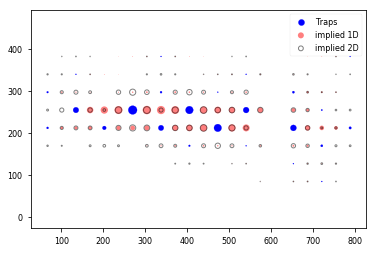

In [7]:
# Interploation... 1D vs 2D
# 2D doesn't make sense here, but is interesting comparison and useful for future point release work
rep = 1
treatment = 'Super High'
service_number = 0

df = load_rep_catch_data(rep, FN)
df['x'] = df.apply(lambda r: tx0[int(r['Trap #'])-1] 
                   if int(r['Row']%10) == 5
                   else tx1[int(r['Trap #'])-1],
                   axis=1) 
df['y'] = df['Row'] * ROWSPACE

tmp = df[df['Treatment'] == treatment]
service_dates = pd.to_datetime(tmp['Date Collected'].unique())
display(service_dates)
service_date = service_dates[service_number]
tmp = tmp[tmp['Date Collected'] == service_date]

# plot traps
fig = plt.figure()
ax = fig.add_subplot(1,1,1)    
x = tmp['x']
y = tmp['y']
z = tmp['Total']
ax.scatter(x, y, z, color='b', label='Traps')


### Blocks
if treatment.lower() == 'low':
    bx = []
    by = []
elif treatment.lower() == 'high':
    bx = hbx
    by = hby
elif treatment.lower() == 'super high':
    bx = shbx
    by = shby
else:
    raise RuntimeError("don't understand treatment='{}'".format(treatment))
foo = tmp.copy(deep=True)
foo['isTrap'] = True
foo = foo.append(pd.DataFrame({'x':bx, 'y':by}),
           ignore_index=True)
foo.sort_values(['y','x'], inplace=True)
foo.reset_index(inplace=True, drop=True)

# interpolate
## 1D (row wise) interpolation
out = foo.copy(deep=True)
foo['iT'] = np.nan
for row in sorted(foo['y'].unique()):
    tmp = foo[foo['y']==row].sort_values('x')
    tmp2 = tmp.dropna(subset=['Total'])
    iT = scipy.interpolate.interp1d(tmp2['x'], tmp2['Total'], 
                                    kind='linear', copy=True, bounds_error=False, 
                                    fill_value=np.nan, assume_sorted=False)(tmp['x'])
    foo.loc[tmp.index,'implied catch 1D'] = iT

# 2D interploation... Doesn't seem to make sense for transect release
# @TCC Doesn't seem to work for the cross-transect nature of the data (y and x distances aren't equivalent)
# uses x,y,z for traps only computed above
foo['implied catch 2D'] = scipy.interpolate.griddata(list(zip(x,y)),z, 
                                list(zip(foo['x'],foo['y'])),
                                method='linear', fill_value=np.nan, rescale=False)

# plot just the blocks
t2 = foo[foo['isTrap']!=True]
ax.scatter(t2['x'], t2['y'], t2['implied catch 1D'], color='r', alpha=0.5, edgecolor='none', linewidths=1, label='implied 1D')
ax.scatter(t2['x'], t2['y'], t2['implied catch 2D'], color='none', alpha=0.5, edgecolor='k', linewidths=1, label='implied 2D')
ax.set_aspect('equal','datalim')
ax.legend()

## Distribution of catch vs distance from transect

In [8]:
# Load data and filter down to single service (collection date)
rep = 1
treatment = 'Low'
service_number = 0

df = load_rep_catch_data(rep, FN)
df['x'] = df.apply(lambda r: tx0[int(r['Trap #'])-1] 
                   if int(r['Row']%10) == 5
                   else tx1[int(r['Trap #'])-1],
                   axis=1) 
df['y'] = df['Row'] * ROWSPACE

df = df[df['Treatment'] == treatment]
service_dates = pd.to_datetime(df['Date Collected'].unique())
print("Service Dates:", service_dates) # just informative output
service_date = service_dates[service_number]
df = df[df['Date Collected'] == service_date]

df['rel catch'] = df['Total']/df['Total'].sum()

Service Dates: DatetimeIndex(['2017-04-13', '2017-04-17', '2017-04-27', '2017-05-01'], dtype='datetime64[ns]', freq=None)


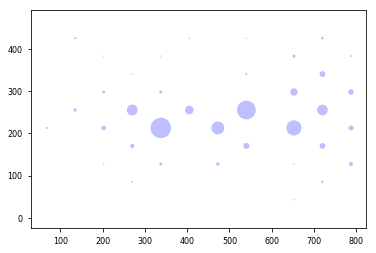

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)    
x = df['x']
y = df['y']
z = df['Total']
ax.scatter(x, y, z, color='b', alpha=0.25, label='Traps')
ax.set_aspect('equal','datalim')

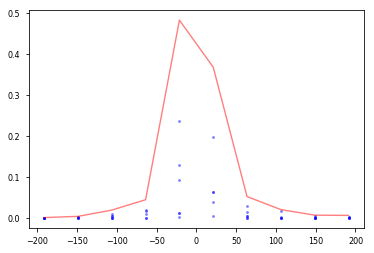

In [10]:
release_y = 27.5*ROWSPACE

df['dy'] = df['y']-release_y

fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
ax.plot(df['dy'], df['rel catch'], '.', alpha=0.5, color='b')

cdy = df.groupby('dy')['rel catch'].sum()
ax.plot(cdy.index, cdy, 'r-', alpha=0.5)

Service Dates: DatetimeIndex(['2017-04-13', '2017-04-17', '2017-04-27', '2017-05-01'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-05-04', '2017-05-08', '2017-05-18', '2017-05-22'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-06-01', '2017-06-05', '2017-06-15', '2017-06-19'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-04-13', '2017-04-17', '2017-04-27', '2017-05-01'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-05-04', '2017-05-08', '2017-05-18', '2017-05-22'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-06-01', '2017-06-05', '2017-06-15', '2017-06-19'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-04-13', '2017-04-17', '2017-04-27', '2017-05-01'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-05-04', '2017-05-08', '2017-05-18', '2017-05-22'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeI

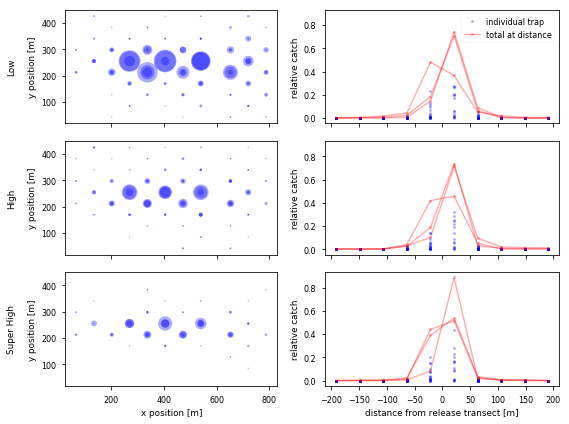

In [11]:
# Load data and filter down to single service (collection date)
treatments = ['Low', 'High', 'Super High']
reps = [1,2,3]
service_number = 0
release_y = 27.5 * ROWSPACE

fig = plt.figure(figsize=[8,6])
#gs = mpl.gridspec.GridSpec(len(treatments),2)
axs = fig.subplots(len(treatments), 2, sharex='col', sharey='col')

for ti, treatment in enumerate(treatments):
    for rep in reps:
        
        df = load_rep_catch_data(rep, FN)
        df['x'] = df.apply(lambda r: tx0[int(r['Trap #'])-1] 
                           if int(r['Row']%10) == 5
                           else tx1[int(r['Trap #'])-1],
                           axis=1) 
        df['y'] = df['Row'] * ROWSPACE
#         full_df = df.copy()
#         df = full_df.copy()

        df = df[df['Treatment'] == treatment]
        service_dates = pd.to_datetime(df['Date Collected'].unique())
        print("Service Dates:", service_dates) # just informative output
        service_date = service_dates[service_number]
        df = df[df['Date Collected'] == service_date]

        df['rel catch'] = df['Total']/df['Total'].sum()
        df['dy'] = df['y']-release_y
        cdy = df.groupby('dy')['rel catch'].sum()

        ax = axs[ti,0]
        ax.scatter(df['x'], df['y'], df['Total'], color='b', alpha=0.33, label='trap catch')
        ax.set_aspect('equal')
        ax.set_ylabel('{}\n\ny position [m]'.format(treatment))

        ax = axs[ti,1]
        tmp, = ax.plot(df['dy'], df['rel catch'], '.', alpha=0.33, color='b', label='')
        if rep == reps[0]: tmp.set_label('individual trap')
        tmp, = ax.plot(cdy.index, cdy, 'r.-', alpha=0.33, label='')
        if rep == reps[0]: tmp.set_label('total at distance')
        ax.set_ylabel('relative catch')
    
axs[0,1].legend()
axs[-1,0].set_xlabel('x position [m]')
axs[-1,1].set_xlabel('distance from release transect [m]')

fig.tight_layout()


In [12]:
### Averaging the 3 reps

<IPython.core.display.Javascript object>


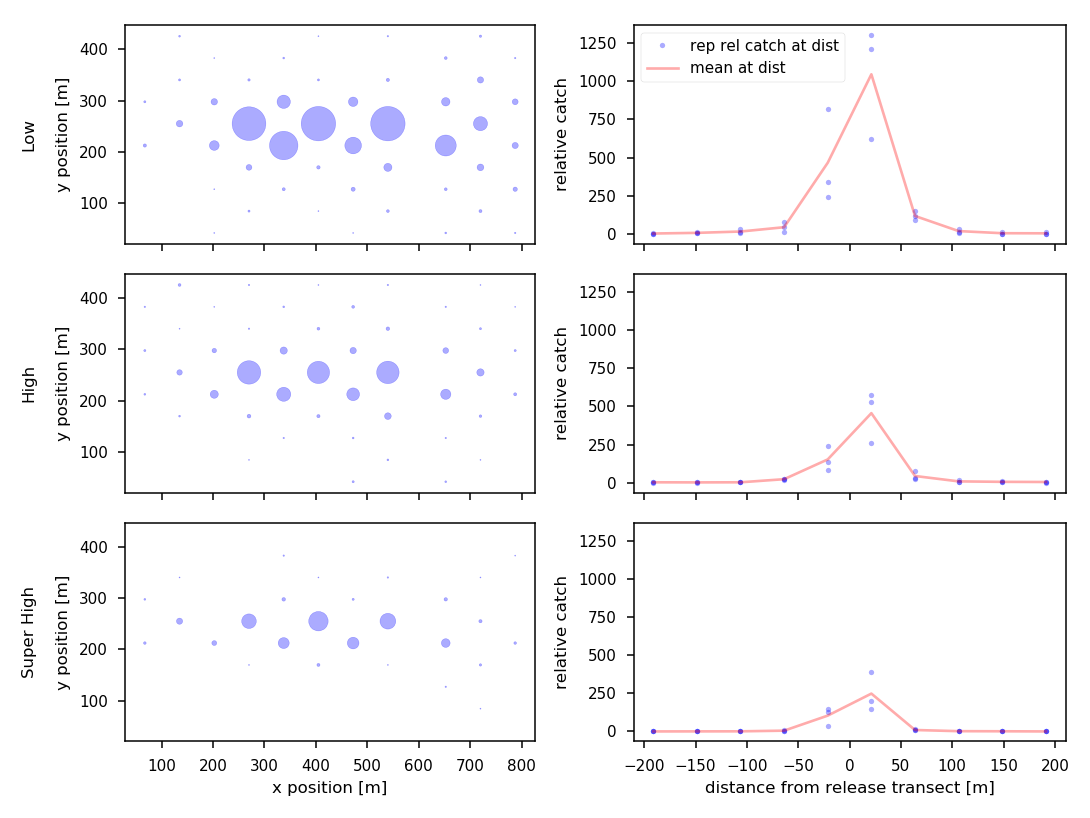

Service Dates: DatetimeIndex(['2017-04-13', '2017-04-17', '2017-04-27', '2017-05-01'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-05-04', '2017-05-08', '2017-05-18', '2017-05-22'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-06-01', '2017-06-05', '2017-06-15', '2017-06-19'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-04-13', '2017-04-17', '2017-04-27', '2017-05-01'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-05-04', '2017-05-08', '2017-05-18', '2017-05-22'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-06-01', '2017-06-05', '2017-06-15', '2017-06-19'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-04-13', '2017-04-17', '2017-04-27', '2017-05-01'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-05-04', '2017-05-08', '2017-05-18', '2017-05-22'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeI

In [54]:
# Load data and filter down to single service (collection date)
treatments = ['Low', 'High', 'Super High']
reps = [1,2,3]
service_number = 0
release_y = 27.5 * ROWSPACE
SCATTER_MARKER_SCALE = 1

fig = plt.figure(figsize=[8,6])
axs = fig.subplots(len(treatments), 2, sharex='col', sharey='col', squeeze=False)

dys_by_treatment = {}
for ti, treatment in enumerate(treatments):
    dys = None
    sc = None
    for rep in reps:
        df = load_rep_catch_data(rep, FN)
        df['x'] = df.apply(lambda r: tx0[int(r['Trap #'])-1] 
                           if int(r['Row']%10) == 5
                           else tx1[int(r['Trap #'])-1],
                           axis=1) 
        df['y'] = df['Row'] * ROWSPACE
        df = df[df['Treatment'] == treatment]
        service_dates = pd.to_datetime(df['Date Collected'].unique())
        print("Service Dates:", service_dates) # just informative output
        service_date = service_dates[service_number]
        df = df[df['Date Collected'] == service_date]

        df['rel catch'] = df['Total']#/df['Total'].sum()
        
#         if treatment == 'High':
#             df['rel catch'] = df['rel catch']*2
#         if treatment == 'Super High':
#             df['rel catch'] = df['rel catch']*4
            
        df['dy'] = df['y']-release_y
        cdy = df.groupby('dy')['rel catch'].sum()
        cdy.name = rep

        if dys is None:
            dys = cdy.to_frame()
            sc = df.copy().loc[:,['x','y','rel catch','dy']]
            sc.rename(columns={'rel catch':'rel catch{}'.format(rep)}, inplace=True)
        else:
            dys = dys.join(cdy.to_frame(), how='outer')
            sc = sc.merge(df.loc[:,['x','y','rel catch']].rename(columns={'rel catch':'rel catch{}'.format(rep)}),
                          how='outer', left_on=['x','y'], right_on=['x','y'], suffixes=['',rep])

    sc['mean'] = sc.loc[:,sc.columns.str.startswith('rel catch')].mean(axis=1)
    dys_by_treatment[treatment] = dys.copy()

    ax = axs[ti,0]
    ax.scatter(sc['x'], sc['y'], sc['mean']*SCATTER_MARKER_SCALE, color='b', alpha=0.33, label='mean relative trap catch')
    ax.set_aspect('equal')
    ax.set_ylabel('{}\n\ny position [m]'.format(treatment))

    ax = axs[ti,1]
    for rep in reps:
        tmp, = ax.plot(dys.index, dys.loc[:,rep], '.', alpha=0.33, color='b', label='')
        if rep == reps[0]: tmp.set_label('rep rel catch at dist')
    ax.plot(dys.index, dys.mean(axis=1), 'r-', alpha=0.33, label='mean at dist')
    ax.set_ylabel('relative catch')

axs[0,1].legend()
axs[-1,0].set_xlabel('x position [m]')
axs[-1,1].set_xlabel('distance from release transect [m]')

fig.tight_layout()

In [14]:
dys_by_treatment

{'Low':                 1         2         3
 dy                                   
 -191.25  0.000588  0.003064  0.000543
 -148.75  0.003529  0.001838  0.005975
 -106.25  0.018824  0.001838  0.005975
 -63.75   0.044118  0.006740  0.024443
 -21.25   0.481765  0.146446  0.185225
  21.25   0.367059  0.742034  0.708311
  63.75   0.051765  0.090074  0.063552
  106.25  0.020000  0.007353  0.004889
  148.75  0.006471  0.000000  0.001086
  191.25  0.005882  0.000613  0.000000,
 'High':                 1         2         3
 dy                                   
 -191.25  0.004950  0.004161  0.000000
 -148.75  0.002475  0.000000  0.005291
 -106.25  0.004950  0.002774  0.001764
 -63.75   0.030941  0.026352  0.042328
 -21.25   0.102723  0.188627  0.419753
  21.25   0.714109  0.736477  0.456790
  63.75   0.096535  0.031900  0.052910
  106.25  0.021040  0.008322  0.003527
  148.75  0.013614  0.001387  0.007055
  191.25  0.008663  0.000000  0.010582,
 'Super High':                 1         2     

### Fit to gaussian (y position, not just distance)


<IPython.core.display.Javascript object>


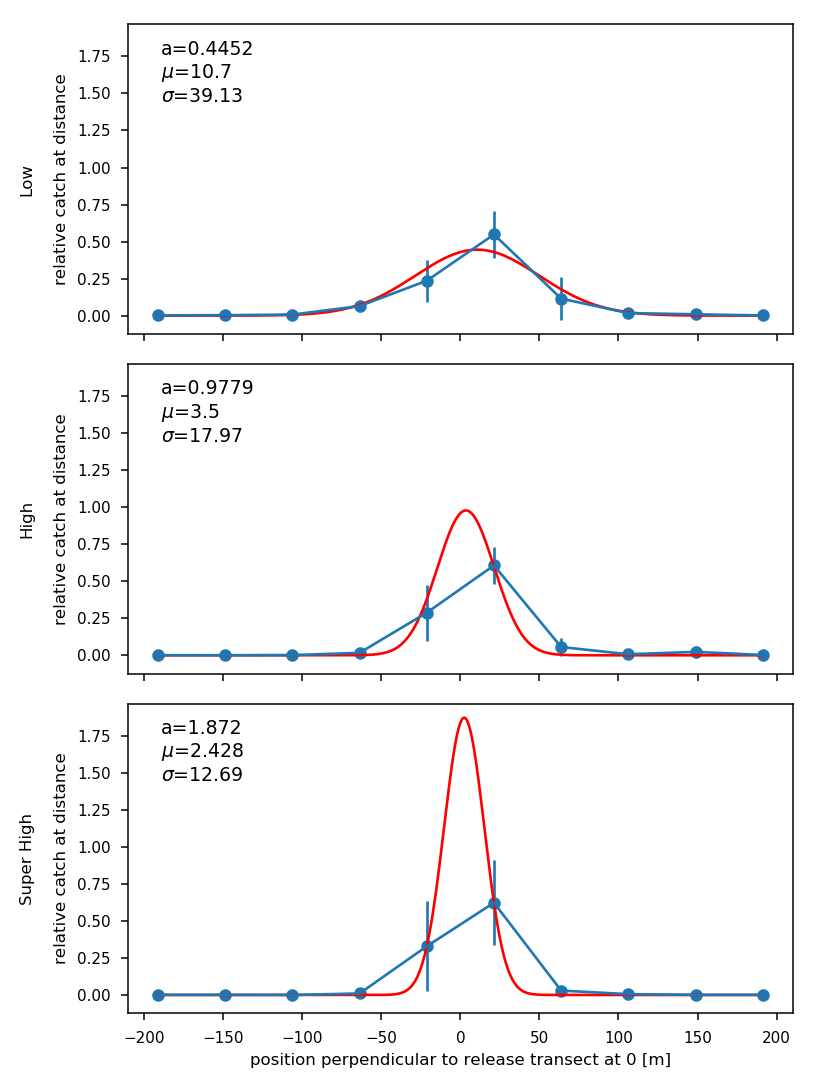

Low [ 0.44515328 10.69555886 39.13138107]
High [ 0.9779326   3.49994897 17.96712213]
Super High [ 1.87191253  2.42750104 12.69016315]


In [49]:
# Create a function which returns a Gaussian (normal) distribution.
def gauss(x, *p):
	a, b, c = p # b=mu, c=sigma (could also add d)
	y = a*np.exp(-np.power((x - b), 2.)/(2. * c**2.))# + d
	return y

treatments = ['Low', 'High', 'Super High']

fig = plt.figure(figsize=[6,8])
axs = fig.subplots(len(treatments), 1, sharex='col', sharey='col', squeeze=False)

for ti, treatment in enumerate(treatments):
    d = dys_by_treatment[treatment]
    d = d.stack().reset_index()
    d.rename(columns={'level_1':'rep', 0:'rc'}, inplace=True)

    N = 1000
    gb = d.groupby('dy')
    tmp = gb.mean()['rc']
    x = tmp.index.values
    y = tmp.values
    e = gb.std()['rc'].values

    y[y==0] = np.finfo(float).eps
    e[e==0] = np.finfo(float).eps
    
#     p_initial = [ 1,   5.87885532,  29.35313084]
    p_initial = [.1, (d['dy']*d['rc']).mean(), (d['dy']*d['rc']).std()]

    # Use curve_fit to fit
    popt, pcov = scipy.optimize.curve_fit(gauss, x, y, sigma=e, absolute_sigma=True, p0=p_initial, maxfev=1000)

    # Generate y-data based on the fit
    y_fit = gauss(x, *popt)
    print(treatment, popt)
    
    ax = axs[ti,0]
    ax.errorbar(x,y,e)
    ax.plot(x,y, 'o', mew=1, color='C0')
    x2 = np.linspace(x.min(), x.max(), N)
    ax.plot(x2, gauss(x2, *popt), color = 'red')
    
    ax.annotate("a={:.4g}\n$\\mu$={:.4g}\n$\\sigma$={:.4g}".format(*popt),
               xy=(.05,.95), xycoords='axes fraction',
               horizontalalignment='left', verticalalignment='top')
    ax.set_ylabel('{}\n\nrelative catch at distance'.format(treatment))
axs[-1,0].set_xlabel('position perpendicular to release transect at 0 [m]')
fig.tight_layout()

### Distance to transect fit


<IPython.core.display.Javascript object>


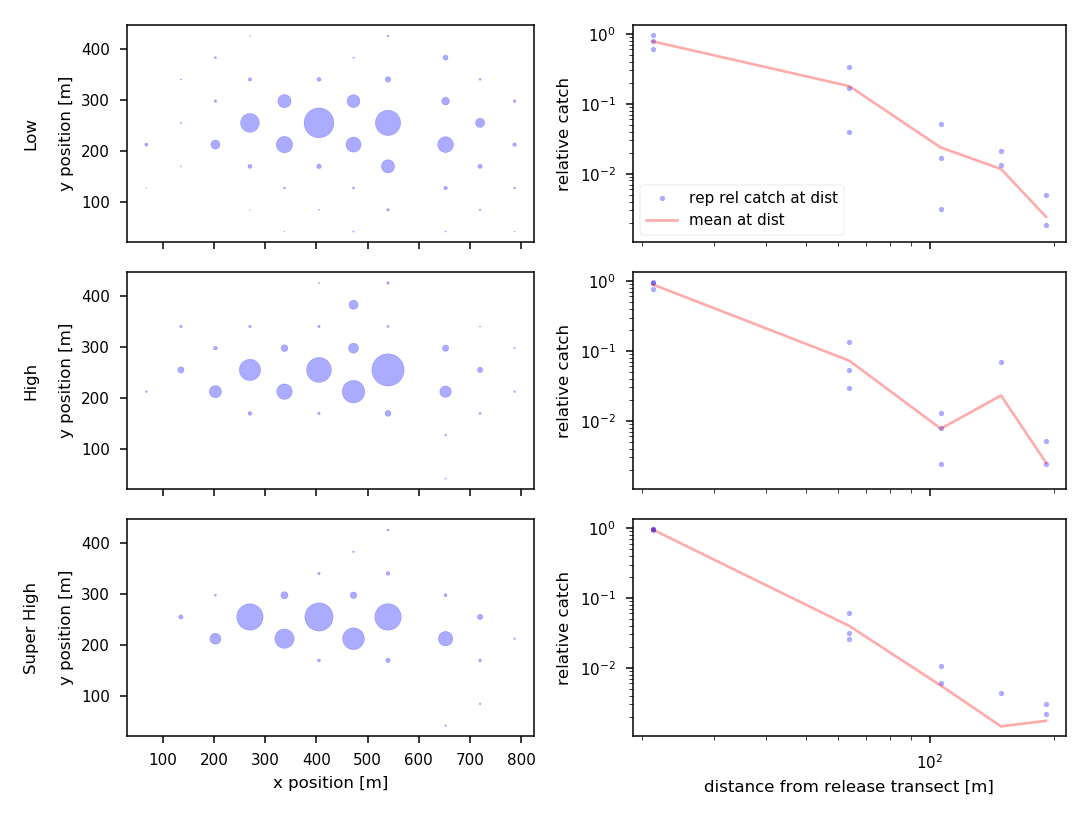

Service Dates: DatetimeIndex(['2017-04-13', '2017-04-17', '2017-04-27', '2017-05-01'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-05-04', '2017-05-08', '2017-05-18', '2017-05-22'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-06-01', '2017-06-05', '2017-06-15', '2017-06-19'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-04-13', '2017-04-17', '2017-04-27', '2017-05-01'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-05-04', '2017-05-08', '2017-05-18', '2017-05-22'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-06-01', '2017-06-05', '2017-06-15', '2017-06-19'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-04-13', '2017-04-17', '2017-04-27', '2017-05-01'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeIndex(['2017-05-04', '2017-05-08', '2017-05-18', '2017-05-22'], dtype='datetime64[ns]', freq=None)
Service Dates: DatetimeI

In [47]:
# Load data and filter down to single service (collection date)
treatments = ['Low', 'High', 'Super High']
reps = [1,2,3]
service_number = 0
release_y = 27.5 * ROWSPACE
SCATTER_MARKER_SCALE = 1000

fig = plt.figure(figsize=[8,6])
axs = fig.subplots(len(treatments), 2, sharex='col', sharey='col', squeeze=False)

dys_by_treatment = {}
for ti, treatment in enumerate(treatments):
    dys = None
    sc = None
    for rep in reps:
        df = load_rep_catch_data(rep, FN)
        df['x'] = df.apply(lambda r: tx0[int(r['Trap #'])-1] 
                           if int(r['Row']%10) == 5
                           else tx1[int(r['Trap #'])-1],
                           axis=1) 
        df['y'] = df['Row'] * ROWSPACE
        df = df[df['Treatment'] == treatment]
        service_dates = pd.to_datetime(df['Date Collected'].unique())
        print("Service Dates:", service_dates) # just informative output
        service_date = service_dates[service_number]
        df = df[df['Date Collected'] == service_date]

        df['rel catch'] = df['Total']/df['Total'].sum()
        df['dy'] = np.abs(df['y']-release_y)
        cdy = df.groupby('dy')['rel catch'].sum()
        cdy.name = rep

        if dys is None:
            dys = cdy.to_frame()
            sc = df.copy().loc[:,['x','y','rel catch','dy']]
            sc.rename(columns={'rel catch':'rel catch{}'.format(rep)}, inplace=True)
        else:
            dys = dys.join(cdy.to_frame(), how='outer')
            sc = sc.merge(df.loc[:,['x','y','rel catch']].rename(columns={'rel catch':'rel catch{}'.format(rep)}),
                          how='outer', left_on=['x','y'], right_on=['x','y'], suffixes=['',rep])

    sc['mean'] = sc.loc[:,sc.columns.str.startswith('rel catch')].mean(axis=1)
    dys_by_treatment[treatment] = dys.copy()

    ax = axs[ti,0]
    ax.scatter(sc['x'], sc['y'], sc['mean']*SCATTER_MARKER_SCALE, color='b', alpha=0.33, label='mean relative trap catch')
    ax.set_aspect('equal')
    ax.set_ylabel('{}\n\ny position [m]'.format(treatment))

    ax = axs[ti,1]
    for rep in reps:
        tmp, = ax.plot(dys.index, dys.loc[:,rep], '.', alpha=0.33, color='b', label='')
        if rep == reps[0]: tmp.set_label('rep rel catch at dist')
    ax.plot(dys.index, dys.mean(axis=1), 'r-', alpha=0.33, label='mean at dist')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel('relative catch')

axs[0,1].legend()
axs[-1,0].set_xlabel('x position [m]')
axs[-1,1].set_xlabel('distance from release transect [m]')

fig.tight_layout()

In [43]:
for k,v in dys_by_treatment.items():
    print(k, v, v.mean(axis=1))

Low                1         2         3
dy                                  
21.25   0.848824  0.888480  0.893536
63.75   0.095882  0.096814  0.087996
106.25  0.038824  0.009191  0.010864
148.75  0.010000  0.001838  0.007061
191.25  0.006471  0.003676  0.000543 dy
21.25     0.876947
63.75     0.093564
106.25    0.019626
148.75    0.006300
191.25    0.003563
dtype: float64
High                1         2         3
dy                                  
21.25   0.816832  0.925104  0.876543
63.75   0.127475  0.058252  0.095238
106.25  0.025990  0.011096  0.005291
148.75  0.016089  0.001387  0.012346
191.25  0.013614  0.004161  0.010582 dy
21.25     0.872826
63.75     0.093655
106.25    0.014126
148.75    0.009941
191.25    0.009452
dtype: float64
Super High                1         2         3
dy                                  
21.25   0.925532  0.970588  0.955326
63.75   0.058511  0.022624  0.037801
106.25  0.007979  0.004525  0.006873
148.75  0.007979  0.002262  0.000000
191.25  0.0000

In [21]:
dys_by_treatment

{'Low':                1         2         3
 dy                                  
 21.25   0.848824  0.888480  0.893536
 63.75   0.095882  0.096814  0.087996
 106.25  0.038824  0.009191  0.010864
 148.75  0.010000  0.001838  0.007061
 191.25  0.006471  0.003676  0.000543,
 'High':                1         2         3
 dy                                  
 21.25   0.816832  0.925104  0.876543
 63.75   0.127475  0.058252  0.095238
 106.25  0.025990  0.011096  0.005291
 148.75  0.016089  0.001387  0.012346
 191.25  0.013614  0.004161  0.010582,
 'Super High':                1         2         3
 dy                                  
 21.25   0.925532  0.970588  0.955326
 63.75   0.058511  0.022624  0.037801
 106.25  0.007979  0.004525  0.006873
 148.75  0.007979  0.002262  0.000000
 191.25  0.000000  0.000000  0.000000}

/home/travc/miniconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Low [10.19905009  5.66074012  7.03733609]
High [10.51444363  5.8610664   6.89765182]
Super High [7.72466445 4.78383453 8.04385581]


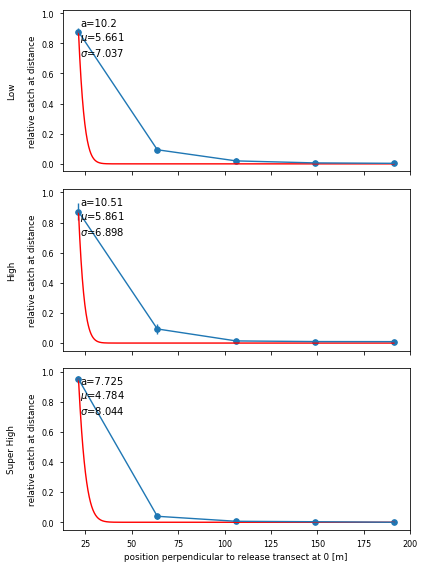

In [23]:
def gauss(x, *p):
	a, b, c = p # b=mu, c=sigma (could also add d)
	y = a*np.exp(-np.power((x - b), 2.)/(2. * c**2.))# + d
	return y

treatments = ['Low', 'High', 'Super High']

fig = plt.figure(figsize=[6,8])
axs = fig.subplots(len(treatments), 1, sharex='col', sharey='col', squeeze=False)

for ti, treatment in enumerate(treatments):
    d = dys_by_treatment[treatment]
    d = d.stack().reset_index()
    d.rename(columns={'level_1':'rep', 0:'rc'}, inplace=True)

    N = 1000
    gb = d.groupby('dy')
    tmp = gb.mean()['rc']
    x = tmp.index.values
    y = tmp.values
    e = gb.std()['rc'].values

    ## fit
    y[y==0] = np.finfo(float).eps
    e[e==0] = np.finfo(float).eps
    
#     p_initial = [ 1,   5.87885532,  29.35313084]
    p_initial = [.1, (d['dy']*d['rc']).mean(), (d['dy']*d['rc']).std()]

    # Use curve_fit to fit
    popt, pcov = scipy.optimize.curve_fit(gauss, x, y, sigma=e, absolute_sigma=True, p0=p_initial, maxfev=1000)

    # Generate y-data based on the fit
    y_fit = gauss(x, *popt)
    print(treatment, popt)
    
    ax = axs[ti,0]
    ax.errorbar(x,y,e)
    ax.plot(x,y, 'o', mew=1, color='C0')
    x2 = np.linspace(x.min(), x.max(), N)
    ax.plot(x2, gauss(x2, *popt), color = 'red')
    
    ax.annotate("a={:.4g}\n$\\mu$={:.4g}\n$\\sigma$={:.4g}".format(*popt),
               xy=(.05,.95), xycoords='axes fraction',
               horizontalalignment='left', verticalalignment='top')
    ax.set_ylabel('{}\n\nrelative catch at distance'.format(treatment))
axs[-1,0].set_xlabel('position perpendicular to release transect at 0 [m]')
fig.tight_layout()